# Octahedral site of FCC Al
Author: Jonathan Frassineti

This example shows how to use the Celio approximation as implemented in UNDI.
The simulations that follow reproduce the case of Al for different external magnetic fields along the [1.,1.,1.] axis.
The comparison between the case with positive electric field gradient (EFG) and negative EFG is shown.
For the physical aspects, see A.Yaouanc and P. de Réotier, Muon Spin Rotation, Relaxation and Resonance,
Oxford University Press, 2010, chapter 7, Fig. 7.8.

In [1]:
try:
    from undi import MuonNuclearInteraction
except (ImportError, ModuleNotFoundError):
    import sys
    sys.path.append('../undi')
    from undi import MuonNuclearInteraction
import matplotlib.pyplot as plt
import numpy as np

Define physical constants.

In [2]:
angtom = 1.0e-10 # m, Angstrom.
a = 4.0495*1.05 # Al lattice constant, in Angstrom, distorted by the muon presence.
elementary_charge = 1.6021766e-19 # Elementary charge, in Coulomb = Ampere*second.
epsilon0 = 8.8541878e-12 # Vacuum permittivity, in Ampere^2*kilogram^−1*meter^−3*second^4.
h = 6.6260693e-34 # J*s, Planck's constant.
hbar = h/(2*np.pi) # J*s, reduced Planck's constant.

Quadrupole_moment_Al = 0.1466e-28 # m^2, quadrupole moment of Al.
omega_E = 0.70e6 # Quadrupolar resonance frequency of Al, in us^-1.

Define the rotation matrix that brings the diagonal of the FCC lattice
along z.

In [3]:
R = np.array([[ 0.78867513, -0.21132487, -0.57735027],
              [-0.21132487,  0.78867513, -0.57735027],
              [ 0.57735027,  0.57735027,  0.57735027]])

Define the atomic positions for muon and Al nuclei.

In [4]:
mu_pos = np.array([  0  ,   0.,   0.])
Al_pos = np.array([[ 0. ,   0.,  -0.5],
                   [ 0. ,   0.,   0.5],
                   [ 0.5,   0.,   0.0],
                   [-0.5,   0.,   0.0],
                   [ 0. ,   0.5,  0.0],
                   [ 0. , - 0.5,  0.0]])

Define the atomic structure. Note that positions are rotated first and then
transformed into Cartesian coordinates and SI units.

In [5]:
atoms = [
        {'Position': R.dot(mu_pos)*angtom*a,
         'Label': 'mu'
        }
    ]

for i in range(6):
    atoms.append(
        {'Position': R.dot(Al_pos[i])*angtom*a,
        'Label': '27Al',
        'ElectricQuadrupoleMoment': Quadrupole_moment_Al,
        'OmegaQmu': omega_E
        }
    )

## Polarization function.

The muon polarization is obtained with the method introduced by Celio.

In [6]:
steps = 100
tlist = np.linspace(0, 20e-6, steps) # Time scale, in seconds.

Define the applied external magnetic fields, in Tesla.

In [7]:
LongitudinalFields = np.array([0.0, 0.001, 0.00164, 0.003, 0.00329, 0.004, 0.005, 0.006, 0.0005, 0.002, 0.0045, 0.0055])

#This is the Celio method for the polarization function with positive EFG.
print("Computing signal for positive EFGs...", end='', flush=True)

signal_positive_EFG = np.zeros([len(LongitudinalFields), steps]) # Define the polarization signal with positive EFGs.

for i, B in enumerate(LongitudinalFields):

    # Align the external field along z i.e. parallel to the muon spin.
    B_pos = B*np.array([0.,0.,1.])

    NS_positive = MuonNuclearInteraction(atoms, external_field=B_pos, log_level='warn')

    signal_positive_EFG[i] = NS_positive.celio_onsteroids(tlist,  k=3, single_precision=True)

    del NS_positive

print('done!')

#This is the Celio method for the polarization function with negative EFG.
print("And now for negative EFG...", end='', flush=True)

# Align the external field along z i.e. parallel to the muon spin.
B_neg = LongitudinalFields[2]*np.array([0., 0., 1.])

# change sign
for i, a in enumerate(atoms):
    if 'OmegaQmu' in a.keys():
        atoms[i]['OmegaQmu'] = -a['OmegaQmu']

NS_negative = MuonNuclearInteraction(atoms, external_field=B_neg, log_level='warn')

signal_negative_EFG = NS_negative.celio_onsteroids(tlist,  k=3, single_precision=True)

del NS_negative

print('done again!')

Computing signal for positive EFGs...

100%|██████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.37it/s]

done!
And now for negative EFG...


100%|██████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.41it/s]

done again!


Integrate the different curves to reproduce Fig.7.8 (right).

In [8]:
area = np.trapz(signal_positive_EFG, x = 1e6*tlist, dx = 0.2e-6)

...and the results are:

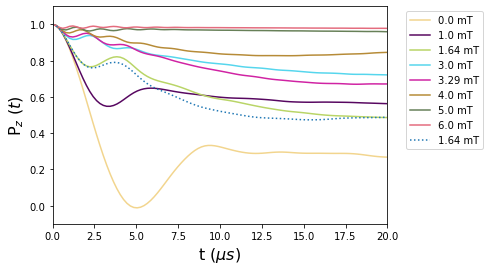

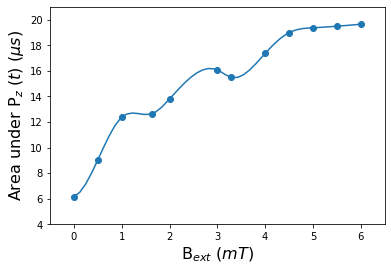

In [9]:
# Plot the polarization functions.

fig1, ax1 = plt.subplots(1,1)

for i in range(8):
    color = list(np.random.choice(range(256), size=3)/256)
    ax1.plot(1e6*tlist, signal_positive_EFG[i], label='{} mT'.format(LongitudinalFields[i]*1e3), linestyle='-', color=color)
ax1.plot(1e6*tlist, signal_negative_EFG, label='{} mT'.format(LongitudinalFields[2]*1e3), linestyle=':')
ax1.set_ylim([-0.1,1.1])
ax1.set_xlim([0,20])
ax1.set_xlabel(r't ($\mu s$)', fontsize=16)
ax1.set_ylabel(r'P$_{z}$ ($t$)', fontsize=16)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

# Plot the integrated areas.
fig2, ax2 = plt.subplots(1,1)

ax2.scatter(LongitudinalFields*1e3, area)
try:
    # add interpolation if scipy is available
    from scipy import interpolate
    f = interpolate.interp1d(LongitudinalFields*1e3,area,kind='cubic')
    x=np.linspace(0,6)
    plt.plot(x, f(x))
except:
    pass


ax2.set_ylim([4,21])
ax2.set_xlim([-0.5,6.5])
ax2.set_xlabel(r'B$_{ext}$ ($mT$)', fontsize=16)
ax2.set_ylabel(r'Area under P$_{z}$ ($t$) ($\mu s$)', fontsize=16)

plt.show()